In [1]:
import matplotlib.pyplot as plt
import numpy as np

import qiskit
from qiskit import QuantumCircuit
from qiskit.providers.aer.noise import NoiseModel, depolarizing_error

from mitiq.zne import mitigate_executor
from mitiq.zne.inference import RichardsonFactory

In [2]:
def variational_circuit(gamma: float) -> QuantumCircuit:
    """Returns a two-qubit circuit for a given variational parameter.

    Args:
        gamma: The variational parameter.

    Returns:
        The two-qubit circuit with a fixed gamma.
    """
    circuit = QuantumCircuit(2)
    circuit.rx(gamma, 0)
    circuit.cnot(0, 1)
    circuit.rx(gamma, 1)
    circuit.cnot(0, 1)
    circuit.rx(gamma, 0)
    
    return circuit

In [3]:
circuit = variational_circuit(gamma=np.pi)
circuit.draw()

┌───────┐                   ┌───────┐
q_0: ┤ Rx(π) ├──■─────────────■──┤ Rx(π) ├
     └───────┘┌─┴─┐┌───────┐┌─┴─┐└───────┘
q_1: ─────────┤ X ├┤ Rx(π) ├┤ X ├─────────
              └───┘└───────┘└───┘

In [4]:
# observable to measure
z = np.diag([1, -1])
hamiltonian = np.kron(z, z)

def noiseless_executor(circuit: QuantumCircuit) -> float:
    """Simulates the execution of a circuit without noise.

    Args:
        circuit: The input circuit.

    Returns:
        The expectation value of the ZZ observable.
    """
    # avoid mutating the input circuit
    circ = circuit.copy()
    circ.save_density_matrix()

    # execute experiment without noise
    job = qiskit.execute(
        experiments=circ,
        backend=qiskit.Aer.get_backend("aer_simulator_density_matrix"),
        noise_model=None,
        # we want all gates to be actually applied,
        # so we skip any circuit optimization 
        optimization_level=0,
        shots=1,
    )
    rho = job.result().data()["density_matrix"]

    expectation = np.real(np.trace(rho @ hamiltonian))
    return expectation 
    


# strength of noise channel
noise_level = 0.04

def executor_with_noise(circuit: QuantumCircuit) -> float:
    """Simulates the execution of a circuit with depolarizing noise.

    Args:
        circuit: The input circuit.

    Returns:
        The expectation value of the ZZ hamiltonian.
    """
    # avoid mutating the input circuit
    circ = circuit.copy()
    circ.save_density_matrix()
    
    # Initialize qiskit noise model. In this case a depolarizing
    # noise model with the same noise strength on all gates
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(
        depolarizing_error(noise_level, 1), ["rx"]
    )
    noise_model.add_all_qubit_quantum_error(
        depolarizing_error(noise_level, 2), ["cx"]
    ) 
    

    # execute experiment with depolarizing noise
    job = qiskit.execute(
        experiments=circ,
        backend=qiskit.Aer.get_backend("aer_simulator_density_matrix"),
        noise_model=noise_model,
        basis_gates=noise_model.basis_gates + ["save_density_matrix"],
        # we want all gates to be actually applied,
        # so we skip any circuit optimization 
        optimization_level=0,
        shots=1,
    )
    rho = job.result().data()["density_matrix"]

    expectation = np.real(np.trace(rho @ hamiltonian))
    return expectation 

In [9]:
gammas = np.linspace(0, 3 * np.pi, 50)
noiseless_expectations = [noiseless_executor(variational_circuit(g)) for g in gammas]

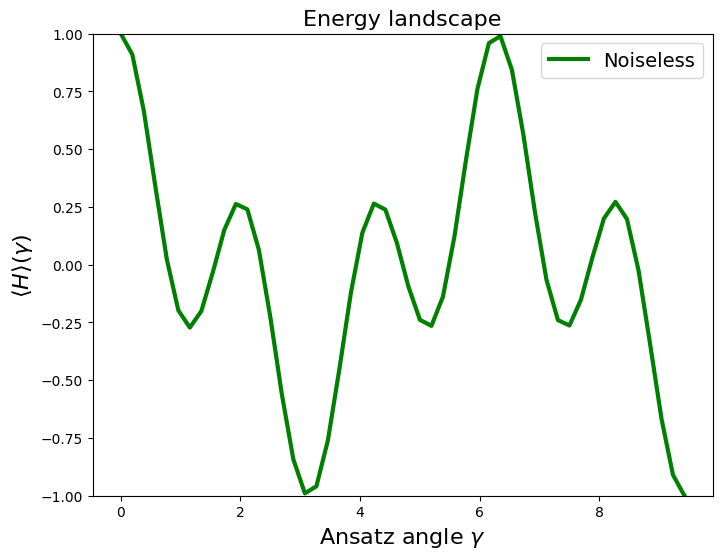

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(gammas, noiseless_expectations, color="g", linewidth=3, label="Noiseless")
plt.title("Energy landscape", fontsize=16)
plt.xlabel(r"Ansatz angle $\gamma$", fontsize=16)
plt.ylabel(r"$\langle H \rangle(\gamma)$", fontsize=16)
plt.legend(fontsize=14)
plt.ylim(-1, 1);
plt.show()

In [17]:
gammas = np.linspace(0, 3 * np.pi, 50)
expectations = [executor_with_noise(variational_circuit(g)) for g in gammas]

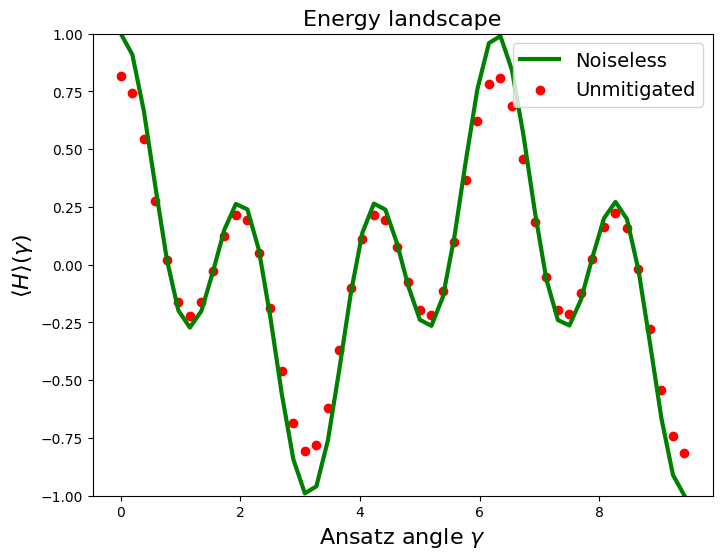

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(gammas, noiseless_expectations, color="g", linewidth=3, label="Noiseless")
plt.scatter(gammas, expectations, color="r", label="Unmitigated")
plt.title(rf"Energy landscape", fontsize=16)
plt.xlabel(r"Ansatz angle $\gamma$", fontsize=16)
plt.ylabel(r"$\langle H \rangle(\gamma)$", fontsize=16)
plt.legend(fontsize=14)
plt.ylim(-1, 1);
plt.show()

In [19]:
fac = RichardsonFactory(scale_factors=[1, 3, 5])
mitigated_executor = mitigate_executor(executor_with_noise, factory=fac)

In [20]:
mitigated_expectations = [mitigated_executor(variational_circuit(g)) for g in gammas]

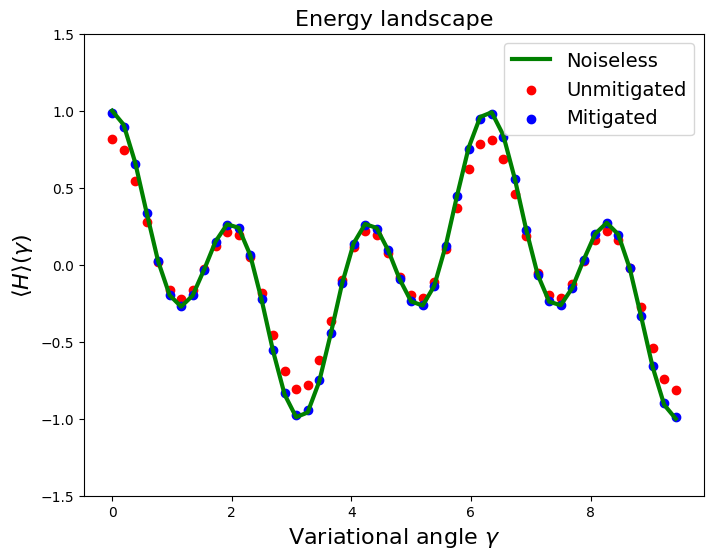

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(gammas, noiseless_expectations, color="g", linewidth=3, label="Noiseless")
plt.scatter(gammas, expectations, color="r", label="Unmitigated")
plt.scatter(gammas, mitigated_expectations, color="b", label="Mitigated")
plt.title(rf"Energy landscape", fontsize=16)
plt.xlabel(r"Variational angle $\gamma$", fontsize=16)
plt.ylabel(r"$\langle H \rangle(\gamma)$", fontsize=16)
plt.legend(fontsize=14)
plt.ylim(-1.5, 1.5);
plt.show()

In [22]:
print(f"Minimum of the noisy landscape: {round(min(expectations), 3)}")
print(f"Minimum of the mitigated landscape: {round(min(mitigated_expectations), 3)}")
print(f"Theoretical ground state energy: {min(np.linalg.eigvals(hamiltonian))}")

Minimum of the noisy landscape: -0.815
Minimum of the mitigated landscape: -0.986
Theoretical ground state energy: -1.0
